# Computing flow past a cylinder in `ViscousFlow`

In [1]:
using Pkg
Pkg.activate("/Users/jeff/ViscousFlow")

"/Users/jeff/ViscousFlow/Project.toml"

In [2]:
using ViscousFlow

In [3]:
using Plots
pyplot()
clibrary(:colorbrewer)
default(grid = false)

### Solve flow past a stationary body

Set the flow parameters

In [4]:
Re = 200; # Reynolds number
U = 1.0; # Free stream velocity
U∞ = (U,0.0);

Set up points on the body.

In [5]:
n = 157;
body = Bodies.Ellipse(0.5,n)

Elliptical body with 157 points and semi-axes (0.5,0.5)
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


Transform the body to lie at a specific position. Here, we just put it at the origin.

In [6]:
cent = (0.0,0.0)
α = 0.0
T = RigidTransform(cent,α)
T(body) # transform the body to the current configuration

Elliptical body with 157 points and semi-axes (0.5,0.5)
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


Set up the domain and plot the body inside it.

In [7]:
xlim = (-1.0,4.0)
ylim = (-2.0,2.0);

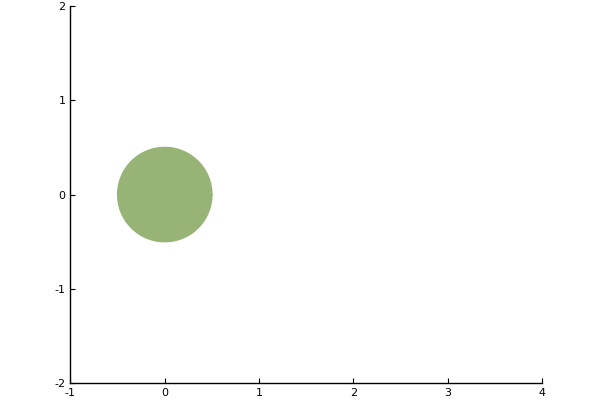

In [8]:
plot(body,xlim=xlim,ylim=ylim)

Now set up the coordinate data for operator construction

In [9]:
X = VectorData(body.x,body.y);
#X̃ = VectorData(body.x̃,body.ỹ);

Set the grid cell size and time step size.

In [29]:
Δx = 0.0203
cfl = 0.5
Δt = min(cfl*Δx,0.5*Δx^2*Re)

0.01015

### Now set up the system

Set up the state vector and constraint force vector for a static body

In [30]:
sys = Systems.NavierStokes(Re,Δx,xlim,ylim,Δt,U∞ = U∞, X̃ = X, isstore = true)

Navier-Stokes system on a grid of size 250 x 200

In [36]:
limits(sys.grid,2)

(-2.0097, 2.0097)

In [37]:
w₀ = Nodes(Dual,size(sys));
f = VectorData(X);

In [38]:
wf = Systems.PointForce(w₀,(1.5,0.0),10.0,4.0,1.0,sys)

Transient point force applied on the Nodes{Dual,250,200} field.
   strength = 10.0
   location = (1.5, 0.0)
   central time = 4.0
   half-interval = 1.0


In [39]:
xg, yg = coordinates(w₀,dx=Δx,I0=Systems.origin(sys))

(-1.02515:0.0203:4.0295499999999995, -2.01985:0.0203:2.01985)

Set up the integrator here

In [40]:
plan_intfact(t,u) = Systems.plan_intfact(t,u,sys)
plan_constraints(u,t) = TimeMarching.plan_constraints(u,t,sys)
r₁(u,t) = TimeMarching.r₁(u,t,sys) + wf(t)
r₂(u,t) = TimeMarching.r₂(u,t,sys)

@time ifherk = IFHERK(w₀,f,sys.Δt,plan_intfact,plan_constraints,(r₁,r₂),rk=TimeMarching.RK31,isstored=true)

  5.103130 seconds (6.25 M allocations: 2.065 GiB, 9.50% gc time)


Order-3 IF-HERK integrator with
   State of type Nodes{Dual,250,200}
   Force of type VectorData{157}
   Time step size 0.01015


Initialize the state vector and the history vectors

In [58]:
t = 0.0
u = deepcopy(w₀)

fx = Float64[];
fy = Float64[];
thist = Float64[];

uhist = [];
tsample = 0.2; # rate at which to store field data

### Advance the system!

Set the time range to integrate over.

In [59]:
tf = 10.0;
T = Δt:Δt:tf;

In [126]:
@time for ti in T
    global t, u, f = ifherk(t,u)
    
    push!(thist,t)
    push!(fx,sum(f.u)*Δx^2)
    push!(fy,sum(f.v)*Δx^2)
    (isapprox(mod(t,tsample),0,atol=1e-8) || isapprox(mod(t,tsample),tsample,atol=1e-8)) ? push!(uhist,u) : nothing
end
println("solution completed through time t = ",t)

 52.163588 seconds (625.96 k allocations: 23.529 GiB, 6.12% gc time)
solution completed through time t = 99.97749999999363


In [110]:
thist[end]

79.98200000000173

#### Plotting

Basic plot

In [65]:
plot(xg,yg,uhist[end],levels=range(-0.1,stop=0.1,length=30), color = :RdBu,clims=(-0.1,0.1),xlim=(-1+Δx,4-Δx),ylim=(-2+Δx,2-Δx),width=1,legend=:true)
plot!(body)

BoundsError: BoundsError: attempt to access 0-element Array{Any,1} at index [0]

Make a movie

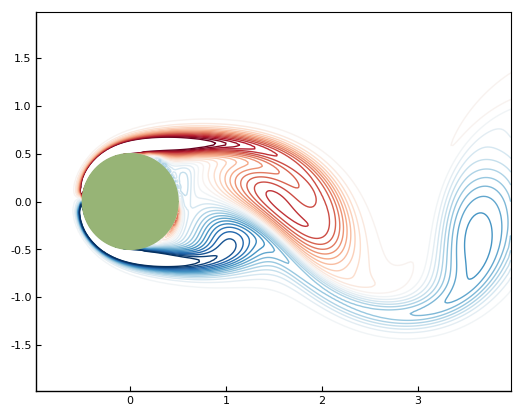

┌ Info: Saved animation to 
│   fn = /Users/jeff/ViscousFlow/examples/cylinderRe200-2.gif
└ @ Plots /Users/jeff/.julia/packages/Plots/QYETN/src/animation.jl:90


Plots.AnimatedGif("/Users/jeff/ViscousFlow/examples/cylinderRe200-2.gif")

In [142]:
anim = @animate for i = 1:length(uhist)
    plot(xg,yg,uhist[i],levels=range(-0.1,stop=0.1,length=30),color = :RdBu,clims=(-0.1,0.1),xlim=(-1+Δx,4-Δx),ylim=(-2+Δx,2-Δx))
    plot!(body)
end
gif(anim,"cylinderRe200-2.gif")

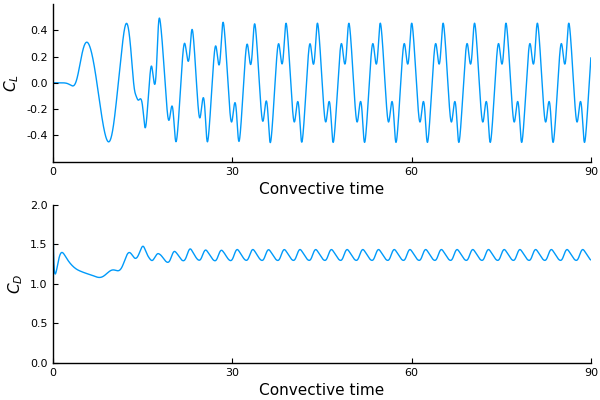

In [120]:
plt = plot(layout = (2,1), size = (600, 400))
plot!(plt[1],thist,2*fy,xlim=(0,90),ylim=(-0.6,0.6),xlabel="Convective time",ylabel="\$C_L\$",legend=false)
plot!(plt[2],thist,2*fx,xlim=(0,90),ylim=(0,2),xlabel="Convective time",ylabel="\$C_D\$",legend=false)
plt

In [67]:
using Statistics

In [70]:
thist[end]

39.99100000000114

In [121]:
Statistics.mean(2*fx[2000:end])

1.361513249387222

In [25]:
using Pkg

In [72]:
using FFTW

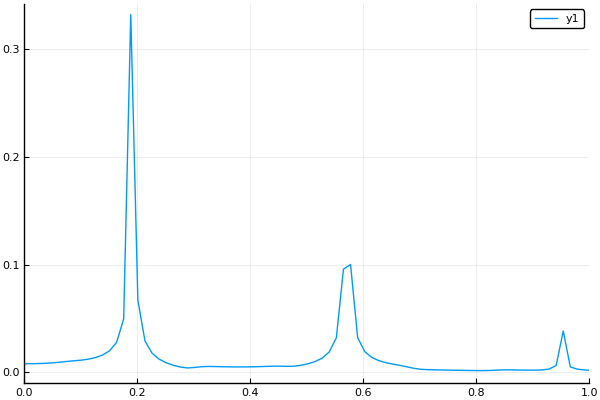

In [127]:
nt = length(thist[2000:end])
nfreq = (nt-1)÷2+1
fsamp = 1/Δt
freq = 0.5*fsamp*range(0,stop=1.0,length=nfreq)
#fhat = fft(fy[2000:nt-1])/(nt-1-2000+1)
fhat = fft(fy[2000:end])/(nt-1)
plot(freq,4*abs.(fhat[1:nfreq]),xlim=(0,1),grid=:true)

In [128]:
freq[findmax(abs.(fhat[1:nfreq]))[2]]

0.18825891876627657

In [89]:
nt

2926

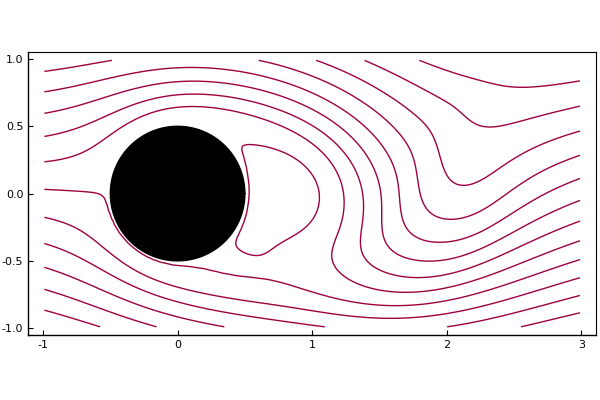

In [39]:
xg,yg = coordinates(u,dx=Δx,I0=Systems.origin(sys))
ψ = deepcopy(uhist[end])
ψ .= -(sys.L\uhist[end])*Δx .+ repeat(collect(yg)',size(sys,1))
plot(xg,yg,ψ,trim=1,clim=(-0.1,0.1))
plot!(body,fillcolor=:black,linecolor=:black)

### Why is this running more slowly than Matlab version

In [171]:
utmp = deepcopy(uhist[end]);
utmp_dt = deepcopy(utmp);

In [360]:
utmp_even = deepcopy(utmp[1:250,1:200]);
utmp_pad = [utmp_even zeros(250,200); zeros(250,200) zeros(250,200)];
#utmp_pad = [utmp_even zeros(250,203); zeros(253,200) zeros(253,203)];
#utmp_pad = [utmp_even zeros(250,232); zeros(262,200) zeros(262,232)];
out_pad = zeros(ComplexF64,size(utmp_pad));
out_pad .= utmp_pad;

In [361]:
FFTW.set_num_threads(2)

In [362]:
F = plan_rfft(utmp_pad);

In [364]:
@time F*utmp_pad

  0.001573 seconds (6 allocations: 1.532 MiB)


251×400 Array{Complex{Float64},2}:
   0.00019575+0.0im          …     89.4206+0.702515im   
  -5.11442e-6-0.000179477im        64.7796-58.097im     
  -0.00015563+4.18763e-5im         8.15051-79.633im     
   9.39557e-5+0.000164985im       -40.9773-55.8425im    
  0.000206674-0.000113392im         -54.58-11.5037im    
  -8.12346e-5-0.000233371im  …    -35.6806+20.0775im    
 -0.000206809+3.43574e-5im        -9.22708+24.4791im    
   2.38864e-5+0.000143517im        3.28397+12.3539im    
   9.42162e-5-5.79356e-5im        0.170203+3.06467im    
  -9.88815e-5-8.53541e-5im        -5.56377+5.16967im    
  -9.63318e-5+0.000113459im  …    -3.09651+12.0761im    
   0.00010881+9.54942e-5im         6.06955+13.1014im    
   8.22833e-5-0.000112063im        12.6174+5.65741im    
             ⋮               ⋱                          
   2.45992e-6+5.47635e-7im      -0.0146235-0.0571613im  
   1.19843e-6-1.55985e-6im   …  -0.0500884-0.0389442im  
  -3.81933e-7-8.88684e-7im      -0.0655423-0.00054212

In [297]:
C = deepcopy(ifherk.H[1].conv)

Circular convolution on a 252 × 202 matrix

In [314]:
C.F

FFTW real-to-complex plan for 503×403 array of Float64
(rdft2-rank>=2/1
  (rdft2-vrank>=1-x403/1
    (rdft2-rdft-r2hc-503/1-0
      (r2hc-dht-503
        (dht-rader-503/1024/is=1/os=1
          (rdft-ct-dit/32
            (hc2hc-direct-32/8 "hf2_32"
              (rdft-r2hc-direct-r2c-32 "r2cf_32")
              (rdft-r2hc01-direct-r2c-32 "r2cfII_32"))
            (rdft-r2hc-directbuf/34-r2c-32-x32 "r2cf_32"))
          (rdft-ct-dit/32
            (hc2hc-direct-32/8 "hf2_32"
              (rdft-r2hc-direct-r2c-32 "r2cf_32")
              (rdft-r2hc01-direct-r2c-32 "r2cfII_32"))
            (rdft-r2hc-directbuf/34-r2c-32-x32 "r2cf_32"))
          (rdft-ct-dit/32
            (hc2hc-direct-32/8 "hf2_32"
              (rdft-r2hc-direct-r2c-32 "r2cf_32")
              (rdft-r2hc01-direct-r2c-32 "r2cfII_32"))
            (rdft-r2hc-directbuf/34-r2c-32-x32 "r2cf_32"))))
      (rdft2-nop)))
  (dft-buffered-403-x63/252-3
    (dft-ct-dif/13
      (dftw-generic-dif-13-31-x63
        (dft-vrank>=1

In [313]:
@time begin
    inds = CartesianIndices((252,202))
    fill!(C.paddedSpace, 0);
    copyto!(C.paddedSpace, inds, utmp, inds);
    mul!(C.Â, C.F, C.paddedSpace);
end

  0.012846 seconds (6 allocations: 224 bytes)


252×403 Array{Complex{Float64},2}:
   0.00019575+0.0im          …     88.7914-0.345896im  
   -3.3191e-6-0.000179681im        63.9179-58.1769im   
 -0.000156522+3.83368e-5im          7.8697-79.2017im   
   8.85163e-5+0.000166995im       -40.7424-55.6827im   
  0.000209739-0.000105787im       -54.4665-11.7982im   
   -7.1678e-5-0.000236889im  …    -36.0116+19.8147im   
 -0.000210329+2.38548e-5im        -9.65322+24.6695im   
    1.3654e-5+0.000147438im        3.26371+12.7993im   
   9.95682e-5-4.84584e-5im        0.540852+3.22451im   
   -8.9712e-5-9.28805e-5im        -5.31441+4.85836im   
 -0.000105983+0.000103927im  …    -3.33936+11.6982im   
   9.86545e-5+0.000106843im        5.55856+13.1626im   
   9.50867e-5-0.000101232im        12.3947+6.16459im   
             ⋮               ⋱                         
   1.90167e-6+1.73168e-6im   …  0.00141125-0.0559821im 
   2.07324e-6-9.48262e-7im      -0.0363415-0.0494282im 
   7.78658e-8-1.44284e-6im      -0.0618406-0.0181438im 
  -2.76535e-7

In [311]:
@time sys.L\utmp

  0.025703 seconds (7 allocations: 397.938 KiB)


Nodes{Dual,252,202} data
Printing in grid orientation (lower left is (1,1))
202×252 Array{Float64,2}:
  6.89753   6.95573   7.01386   7.0719   …   2.03235   2.01568   1.99919
  6.93222   6.99159   7.0509    7.11014      2.021     2.00435   1.98788
  6.96693   7.0275    7.08803   7.14849      2.00947   1.99284   1.97639
  7.00166   7.06345   7.12522   7.18693      1.99774   1.98114   1.96472
  7.03638   7.09942   7.16246   7.22546      1.98583   1.96925   1.95286
  7.07107   7.1354    7.19974   7.26406  …   1.97372   1.95717   1.94081
  7.10573   7.17137   7.23704   7.30271      1.96142   1.9449    1.92858
  7.14034   7.20732   7.27435   7.34139      1.94892   1.93245   1.91616
  7.17486   7.24322   7.31164   7.3801       1.93624   1.9198    1.90355
  7.20929   7.27906   7.34891   7.41881      1.92335   1.90695   1.89075
  7.2436    7.3148    7.38612   7.4575   …   1.91028   1.89392   1.87776
  7.27777   7.35045   7.42325   7.49615      1.897     1.88069   1.86458
  7.31178   7.38596   

In [174]:
size(ifherk.H[1].conv.Ĝ)

(252, 403)

In [169]:
using LinearAlgebra

In [173]:
@time mul!(utmp_dt,ifherk.H[1].conv,utmp)

  0.025277 seconds (4 allocations: 160 bytes)


Nodes{Dual,252,202} data
Printing in grid orientation (lower left is (1,1))
202×252 Array{Float64,2}:
 -2.81044e-17  -3.91217e-17  -4.37362e-17  …  -3.7225e-17   -1.31884e-17
 -4.80967e-17  -5.98921e-17  -6.20353e-17     -8.67433e-17  -4.79542e-17
 -8.20199e-17  -9.58074e-17  -1.02608e-16     -1.0582e-16   -5.86645e-17
 -6.84689e-17  -8.9256e-17   -1.05459e-16     -1.33651e-16  -7.71963e-17
 -5.61592e-17  -7.19602e-17  -8.68802e-17     -1.69372e-16  -9.76103e-17
 -5.53989e-17  -6.83091e-17  -8.12051e-17  …  -1.64247e-16  -8.78964e-17
 -5.60991e-17  -6.92255e-17  -8.14655e-17     -1.31158e-16  -6.45206e-17
 -6.13936e-17  -7.29638e-17  -7.98927e-17     -1.03269e-16  -5.15922e-17
 -5.47831e-17  -6.54593e-17  -7.42951e-17     -6.47771e-17  -2.76798e-17
 -4.76976e-17  -5.79862e-17  -6.73524e-17     -3.2263e-17   -1.19378e-17
 -4.93855e-17  -5.73552e-17  -6.86865e-17  …  -3.5312e-18    8.76183e-18
 -5.1086e-17   -5.61811e-17  -6.65645e-17     -2.75658e-18   2.08833e-18
 -4.25341e-17  -4.6893